In [3]:
import pandas as pd
import re

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
import dotenv
import os

dotenv.load_dotenv()

True

In [ ]:
file_path = # 타이타닉 데이터셋의 루트를 지정해주세요.
df = # 타이타닉 데이터셋을 불러와주세요.

llm = # OpenAI 챗봇을 불러와주세요.

tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="Python Code interpreter",
                        locals={"df":df})    

In [5]:
class State(TypedDict):
    messages : Annotated[list, add_messages]
    code : Annotated[str, "Python Code"]

In [6]:
def create_title_summary(df):

    df_sampled = df.sample(n=5000) if len(df) > 5000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.
           
            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""                                          
            파일 이름 : {file_path.split("/")[-1]}

            1. 제목: 
            2. 요약: 

            """
            )
    
    chain = prompt | llm
    
    result = chain.invoke({"df":df_sampled}).content

    title = "Untitled"
    summary = "No Summary"    

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====\n\n")
    
    return title, summary

In [7]:
title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [8]:
print("제목 : ", title)
print("요약 : ", summary)

제목 :  **타이타닉 생존자 데이터셋**
요약 :  이 데이터셋은 타이타닉 호의 승객 정보를 포함하고 있으며, 총 891명의 승객에 대한 다양한 특성을 기록하고 있습니다. 각 승객의 ID(PassengerId), 생존 여부(Survived), 객실 등급(Pclass), 이름(Name), 성별(Sex), 나이(Age), 형제자매 및 배우자 수(SibSp), 부모 및 자녀 수(Parch), 티켓 번호(Ticket), 요금(Fare), 객실 번호(Cabin), 그리고 탑승 항구(Embarked) 등의 정보가 포함되어 있습니다. 이 데이터는 생존율 분석 및 다양한 인구 통계적 요인과의 관계를 연구하는 데 유용합니다.


In [9]:
class Discriminator(BaseModel):
    """
    주어진 데이터와 관련이 있는 정보인지 판단하고 분석을 할 준비를 진행합니다.
    데이터와 관련이 있는 질문이라면 "yes", 아니라면 "no"라고 답변하세요.
    """

    binary : Literal["yes", "no"] = Field(..., description="""
                                          Determine if the information is relevant to the given data and prepare for analysis.
                                          Answer "yes" if the questions are related to the data, and "no" if the questions can only be answered with existing knowledge.""")

In [10]:
discriminator = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0.,).with_structured_output(Discriminator)

In [11]:
class Judge(BaseModel):
    """
    당신은 AI에이전트입니다.
    가지고 있는 도구는 아래와 같습니다.

    1. PythonAstREPLTool : 텍스트로 된 파이썬 코드를 실행시킬 수 있는 도구

    입력된 값을 기준으로 판단했을 때 도구를 실행시켜야하는 경우라면 'tool', 코드를 실행시키지 않아도 되는 경우에는 'llm'이라고 답변하세요.
    """

    select_tool : Literal["tool", "llm"] = Field(..., description="""
                                                 You are an AI agent.
                                                 The tools you have are as follows.
                                                 
                                                 1. Python AstREPLTool: a tool that allows you to run textual Python code
                                                 
                                                 Answer 'tool' if you need to run the tool based on the input value, or 'llm' if you don't need to run the code.""")

In [12]:
judge = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0.,).with_structured_output(Judge)

In [ ]:
def Discriminate(state:State):

    """
    데이터셋과 관련이 있는지 판단하는 함수
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system","""df : {df}
                    title : {title}
                    summary : {summary}"""),
        ("human", "query : {query}")
    ])

    chain = prompt | discriminator

    result = chain.invoke({"df":df.head(),
                           "title":title,
                           "summary":summary,
                           "query":state["messages"][-1]}).binary
    
    global snapshot
    snapshot = result

    return result

In [ ]:
def Judgement(state:State):

    """
    코드 실행이 필요한지 판단하는 함수
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system",""" 당신은 10년차 데이터 분석 전문가 및 해결사입니다.
                    질문의 결과를 위해 코드 실행이 필요한지 여부를 판단해야합니다.
                    그 판단을 위해 당신에겐 샘플 데이터가 주어집니다.
                    코드 실행이 필요하지 않다면 "llm"이라고 답변하세요.
                    하지만, 코드 실행을 해야한다면 "tool"을 반환합니다.
                    
                    ### 샘플 데이터
                    title : {title}
                    summary : {summary}
                    
                    df : {df}
                    ---

                """),
        ("human", "query : {query}")
    ])

    chain = prompt | judge

    result = chain.invoke({"title":title,
                            "summary":summary,
                            "df" : df.head(),
                            "query":state["messages"][-1]}).select_tool

    global snapshot
    snapshot = result

    return result

In [15]:
def create_code(state:State):
    
    prompt = ChatPromptTemplate([
        ("system", """당신은 pandas, matplotlib 라이브러리를 사용할 수 있는 전문가입니다. 주어진 df의 형태를 참고하여 코드를 작성합니다. \
                    다음은 `print(df.head())`의 형태입니다. {head}
        
                    ### 예시1
                    ```python
        
                    len(df)
                    ```
                    ### 예시2
                    ```python
        
                    # sum_gamerounds에 대한 히스토그램
                    plt.figure(figsize=(12, 6))
                    plt.hist(df['sum_gamerounds'], bins=10, edgecolor='black')
                    plt.title('Distribution of Sum Gamerounds')
                    plt.xlabel('Sum Gamerounds')
                    plt.ylabel('Frequency')
                    plt.grid()
                    plt.show()
                    ```
         
                    ### 주의할 점
                    1. seaborn은 사용하지 않습니다.
        
        """),
        ("human", "{query}")
    ])        
    
    chain = prompt | llm

    result = chain.invoke({
        "head" : df.head(),
        "query" : state["messages"][-1]
    }).content

    try:
        code = re.findall(r'```python\n(.*?)\n```', result, re.DOTALL)[0]

        return {"code" : code}
    except:
        return {"messages" : result,
                "code" : ""}

In [ ]:
def execute_code(state:State):
    # 코드 실행 함수를 만들어주세요.

    return

In [ ]:
def response(state:State):

    """
    답변 함수입니다.
    """

    if snapshot == "no":
        """
        데이터와 관련이 없는 질문일 때 오는 분기
        """

        prompt = # 프롬프트를 입력해주세요.

        chain = # 체인을 구성해주세요.

        answer = # 체인을 실행시켜주세요.
        
        return {"messages":answer}
    
    elif snapshot == "llm":
        """
        데이터와 관련은 있으나 코드 실행과는 무관한 질문일 때 오는 분기
        """

        prompt = ChatPromptTemplate([
            ("system", """
             
             # 프롬프트를 작성해주세요.
            
             제목 : {title}            
             요약 : {summary}

             df : {df}
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "df" : df,
            "query" : state["messages"][-1]
        })

        return {"messages":answer}
    
    else:
        raise Exception("알 수 없는 응답입니다.")

In [22]:
def code_response(state:State):

    if state["code"] == "":

        """
        코드 추출에 실패했을 때 실행되는 분기
        """

        prompt = ChatPromptTemplate([
            ("system", """ 
             당신은 인사이트를 제공해주는는 데이터 분야 10년차 전문가입니다.
             이전 답변과 정보를 기반으로 질문에 대해 답변합니다.
            
             제목 : {title}            
             요약 : {summary}

             답변 : {answer}
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "answer" : state["messages"][:-1],
            "query" : state["messages"][-1]
        })

        return {"messages" : answer}

    else:
        """
        코드 추출에 성공했을 때 실행되는 분기
        """

        prompt = ChatPromptTemplate([
            ("system", """
             
            아래의 코드와 제목, 요약을 참고하여 질의에 대해 답변합니다.
            절대 코드에 대해 설명하지마세요.
            독자는 프로그래머가 아닙니다.
            항상 출력되는 값을 기준으로 설명합니다.
            숫자가 매우 중요합니다. 숫자에 대한 정보를 잊지 마세요.
            데이터 분석과 관련된 코드가 입력된다면 항상 인사이트를 포함하세요.

            제목 : {title}
            요약 : {summary}

            코드 : {code}
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm
        
        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "code" : state["code"],
            "query" : state["messages"][-1]
        })

        return {"messages" : answer}

In [23]:
def pretty_print(state:State):

    print(f"\n\n===== Result =====\n\n")

    print(state["messages"][-1].content)

In [ ]:
def select(state:State):
    """
    단순한 분기점의 역할
    """
    return state

In [28]:
graph_builder = StateGraph(State)

In [ ]:
# 노드를 생성해주세요.



# 엣지를 연결해주세요.

graph_builder.add_conditional_edges(START,
                                    Discriminate,
                                    {
                                    "yes":"select",
                                     "no":"response"
                                     }
                                     )
graph_builder.add_conditional_edges("select",
                                    Judgement,
                                    {
                                    "tool":"create_code",
                                     "llm":"response"
                                     }
                                     )

In [29]:
graph_builder.add_node("select", select)
graph_builder.add_node("create_code", create_code)
graph_builder.add_node("execute_code", execute_code)
graph_builder.add_node("response", response)
graph_builder.add_node("code_response", code_response)
graph_builder.add_node("pretty_print", pretty_print)


graph_builder.add_conditional_edges(START,
                                    Discriminate,
                                    {
                                    "yes":"select",
                                     "no":"response"
                                     }
                                     )
graph_builder.add_conditional_edges("select",
                                    Judgement,
                                    {
                                    "tool":"create_code",
                                     "llm":"response"
                                     }
                                     )
graph_builder.add_edge("create_code", "execute_code")
graph_builder.add_edge("execute_code", "code_response")
graph_builder.add_edge("code_response", "pretty_print")
graph_builder.add_edge("response", "pretty_print")
graph_builder.add_edge("pretty_print", END);

In [30]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

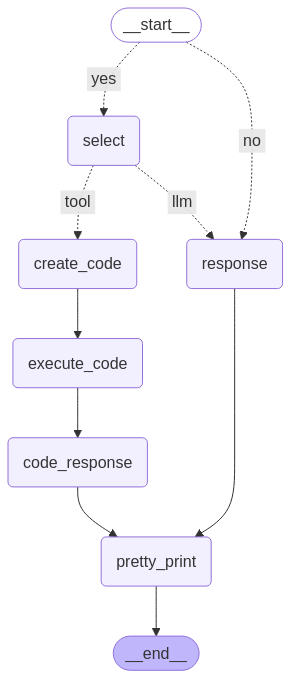

In [37]:
graph

In [31]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1054"})

In [32]:
result = graph.stream({"messages": ("user","생존자의 비율 시각화하고 인사이트 제공해줘.")}, config=config)



=== select ===


================================ Human Message =================================

생존자의 비율 시각화하고 인사이트 제공해줘.


=== create_code ===




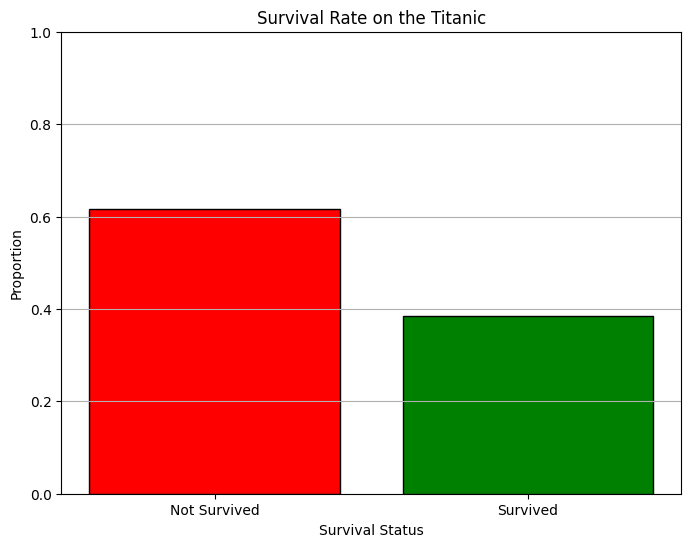

생존자 비율: 38.38%


=== execute_code ===




=== code_response ===




===== Result =====


생존자의 비율은 전체 승객 중에서 생존한 사람의 비율을 나타냅니다. 타이타닉 데이터셋에서 사망자 비율이 61.62%라는 것은 생존자 비율이 100% - 61.62% = 38.38%임을 의미합니다. 

즉, 891명의 승객 중 약 342명이 생존했음을 알 수 있습니다. 이 데이터는 생존자와 사망자의 비율을 통해 타이타닉 사고의 심각성을 보여주며, 생존자 비율이 상대적으로 낮다는 점에서 사고의 치명성을 강조합니다. 

이러한 분석은 생존율에 영향을 미치는 다양한 요인들, 예를 들어 성별, 나이, 객실 등급 등을 추가적으로 연구하는 데 중요한 기초 자료가 될 수 있습니다.


=== pretty_print ===




In [33]:
for step in result:
    for k,v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        try:
            v["messages"][-1].pretty_print()
        except:   
            pass

In [34]:
result = graph.invoke({"messages":("user","아까 내가 질문했던 내용 다시 알려줘")}, config=config)



===== Result =====


당신이 아까 질문했던 내용은 "생존자의 비율 시각화하고 인사이트 제공해줘."였습니다. 이에 대한 답변으로 생존자의 비율과 타이타닉 데이터셋에서의 사망자 비율, 생존율에 영향을 미치는 다양한 요인들에 대한 설명을 드렸습니다. 추가적인 질문이 있으시면 말씀해 주세요!


In [35]:
result = graph.invoke({"messages":("user","아까 물어봤던 숫자들 다 더하면 몇인지 알려줘")}, config=config)



===== Result =====


아까 언급된 숫자는 다음과 같습니다:

- 전체 승객 수: 891명
- 생존자 수: 약 342명
- 사망자 비율: 61.62%

이 숫자들을 더하면:

- 891 + 342 + 61.62 = 1294.62

따라서, 이 숫자들을 모두 더하면 1294.62입니다. 추가적인 질문이 있으시면 말씀해 주세요!


In [36]:
file_path = "./data/athlete_events.csv"
df = pd.read_csv(file_path)

tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="Python Code interpreter",
                        locals={"df":df})    

title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [37]:
print("제목 : ", title)
print()
print("요약 : ", summary)

제목 :  **올림픽 선수 데이터셋: 성별, 나이, 신체 정보 및 경기 성과**

요약 :  이 데이터셋은 5000명의 올림픽 선수에 대한 정보를 포함하고 있으며, 각 선수의 ID, 이름, 성별, 나이, 신장, 체중, 소속 팀, 국가(NOC), 경기 연도 및 시즌, 개최 도시, 스포츠 종목, 이벤트, 그리고 메달 수상 여부를 기록하고 있습니다. 데이터는 다양한 올림픽 경기(여름 및 겨울)에서의 선수들의 성과를 분석하는 데 유용하며, 선수들의 신체적 특성과 성별에 따른 성과 차이를 연구하는 데 기초 자료로 활용될 수 있습니다.


In [38]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1004"})

result = graph.stream({"messages":("user", "이 데이터셋은 어떤 데이터셋이야?")}, config=config)

In [39]:
for step in result:
    for k,v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        try:
            v["messages"][-1].pretty_print()
        except:   
            pass



=== select ===


================================ Human Message =================================

이 데이터셋은 어떤 데이터셋이야?


=== response ===




===== Result =====


이 데이터셋은 올림픽 선수에 대한 정보를 포함하고 있습니다. 총 5000명의 선수에 대한 데이터가 있으며, 각 선수의 ID, 이름, 성별, 나이, 신장, 체중, 소속 팀, 국가(NOC), 경기 연도 및 시즌, 개최 도시, 스포츠 종목, 이벤트, 그리고 메달 수상 여부가 기록되어 있습니다. 이 데이터는 다양한 올림픽 경기(여름 및 겨울)에서 선수들의 성과를 분석하는 데 유용하며, 선수들의 신체적 특성과 성별에 따른 성과 차이를 연구하는 데 기초 자료로 활용될 수 있습니다.


=== pretty_print ===




In [40]:
result = graph.invoke({"messages":("user", "가장 많이 출전한 나라는 어디야?")}, config=config)



===== Result =====


가장 많이 출전한 나라는 **USA**입니다. 이 나라는 총 **18853회** 출전하였습니다. 이는 올림픽에서의 미국 선수들의 활발한 참여를 나타내며, 미국이 올림픽 역사에서 중요한 위치를 차지하고 있음을 보여줍니다.


In [44]:
result = graph.invoke({"messages":("user", "선수들의 평균 체중은 어떻게 돼?")}, config=config)



===== Result =====


선수들의 평균 체중은 70.70 kg입니다. 이 수치는 5000명의 올림픽 선수들의 체중을 기반으로 계산된 값으로, 선수들의 신체적 특성을 이해하는 데 중요한 지표가 됩니다. 평균 체중이 70.70 kg이라는 것은 다양한 스포츠 종목에서 선수들이 이 정도의 체중을 유지하고 있다는 것을 의미하며, 이는 특정 종목의 요구 사항이나 선수들의 훈련 방식과 관련이 있을 수 있습니다.


In [45]:
result = graph.invoke({"messages":("user", "키와 체중, 그리고 메달 획득과의 상관관계를 보고 싶어. 그려줘")}, config=config)



===== Result =====


키와 체중, 그리고 메달 획득 간의 상관관계를 분석하는 것은 흥미로운 접근입니다. 이 데이터셋에는 5000명의 올림픽 선수에 대한 정보가 포함되어 있으며, 각 선수의 신장(키)과 체중, 그리고 메달 수상 여부가 기록되어 있습니다.

1. **키와 체중**: 선수들의 신장과 체중은 신체적 특성을 나타내며, 이 두 요소는 선수의 경기 성과에 영향을 미칠 수 있습니다. 예를 들어, 특정 스포츠 종목에서는 키가 크거나 체중이 적절한 선수가 유리할 수 있습니다.

2. **메달 획득**: 메달 수상 여부는 선수의 성과를 직접적으로 나타내는 지표입니다. 메달을 획득한 선수와 그렇지 않은 선수 간의 신체적 특성을 비교함으로써, 어떤 신체적 특성이 성과에 긍정적인 영향을 미치는지에 대한 인사이트를 얻을 수 있습니다.

이러한 분석을 통해 특정 스포츠 종목에서 성공적인 선수의 신체적 특성을 파악하고, 향후 선수 선발이나 훈련 프로그램 개발에 활용할 수 있는 유용한 정보를 제공할 수 있습니다.
